## Object Detection
- In this notebook, we are going to see how to use a pretrained model and use this model to do object recognition on the real images
- This is to showcase of how to use pretrained model.
    - We are going to see the model signature and then based on that signature, we are going to use HTTP API to get the object detection boundaries.
    - Serving docker image: `Coco.dockerfile`

```
FROM ubuntu:16.04
LABEL maintainer="bugra@ymail.com"
RUN apt-get update && apt-get install -y \
        curl \
        gnupg

RUN echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list
ENV APT_KEY_DONT_WARN_ON_DANGEROUS_USAGE=1
RUN curl -s https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
RUN apt-get update && apt-get install -y \
        tensorflow-model-server

RUN  apt-get clean && \
        rm -rf /var/lib/apt/lists/*

RUN mkdir -p /app/models /app/tf_serving_scripts
COPY models/coco/ /app/models
COPY coco.sh /app/tf_serving_scripts

# GRPC Port
EXPOSE 8500
# HTTP REST API Port
EXPOSE 8501  

ENTRYPOINT ["/bin/sh", "/app/tf_serving_scripts/coco.sh"]
```


#### coco.sh
```
tensorflow_model_server --rest_api_port=8501 --model_name=coco --model_base_path="/app/models" 
```

In [1]:
%matplotlib inline

import json
import os
import sys

# Local Imports
from object_detection.utils import ops as utils_ops
import label_map_util
import visualization_utils as vis_util

# 3rd Party
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf

/usr/local/Cellar/python/3.7.2/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)
/Users/bugraakyildiz/Eng/self/putting-tensorflow-models-to-production/notebooks/visualization_utils.py:27: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  import matplotlib; matplotlib.use('Agg')  # pylint: disable=multiple-statements


In [2]:
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 6) ]
IMAGE_SIZE = (12, 8)

In [3]:
!curl -O http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2017_11_17.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 72.9M  100 72.9M    0     0   737k      0  0:01:41  0:01:41 --:--:--  462k  0   789k      0  0:01:34  0:00:27  0:01:07  698k   0   765k      0  0:01:37  0:01:19  0:00:18  390k


In [4]:
! tar zxvf ssd_mobilenet_v1_coco_2017_11_17.tar.gz

x ssd_mobilenet_v1_coco_2017_11_17/
x ssd_mobilenet_v1_coco_2017_11_17/model.ckpt.index
x ssd_mobilenet_v1_coco_2017_11_17/model.ckpt.meta
x ssd_mobilenet_v1_coco_2017_11_17/frozen_inference_graph.pb
x ssd_mobilenet_v1_coco_2017_11_17/model.ckpt.data-00000-of-00001
x ssd_mobilenet_v1_coco_2017_11_17/saved_model/
x ssd_mobilenet_v1_coco_2017_11_17/saved_model/saved_model.pb
x ssd_mobilenet_v1_coco_2017_11_17/saved_model/variables/
x ssd_mobilenet_v1_coco_2017_11_17/checkpoint


In [5]:
!saved_model_cli show --dir models/fashion_mnist/1 --all


/usr/local/Cellar/python/3.7.2/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_image'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: Conv1_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['Softmax/Softmax:0'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: Softmax/Softmax:0
  Method name is: tensorflow/serving/predict


In [6]:
!saved_model_cli show --dir models/coco/1 --all


/usr/local/Cellar/python/3.7.2/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_image'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: Conv1_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['Softmax_1/Softmax:0'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: Softmax_1/Softmax:0
  Method name is: tensorflow/serving/predict


In [7]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

In [8]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [9]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [10]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict


In [11]:
def plot_images(image_paths):
  for image_path in image_paths:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

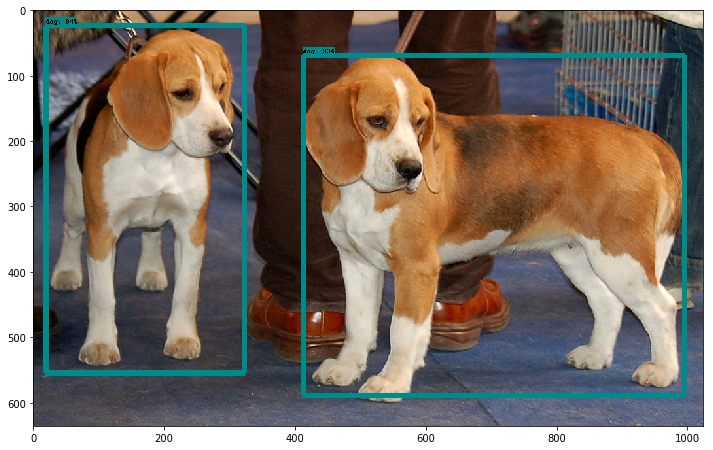

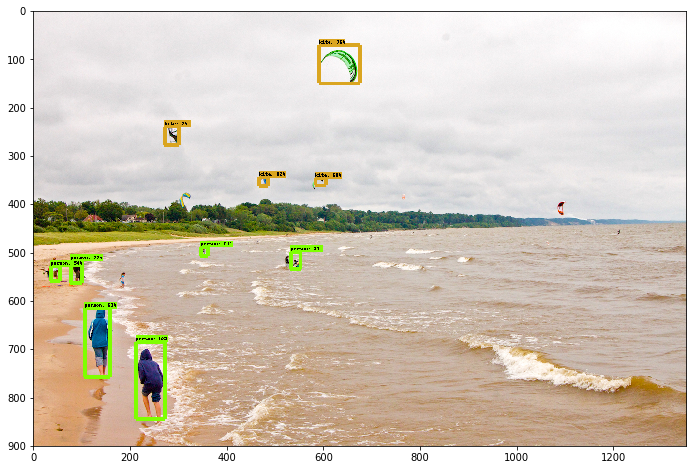

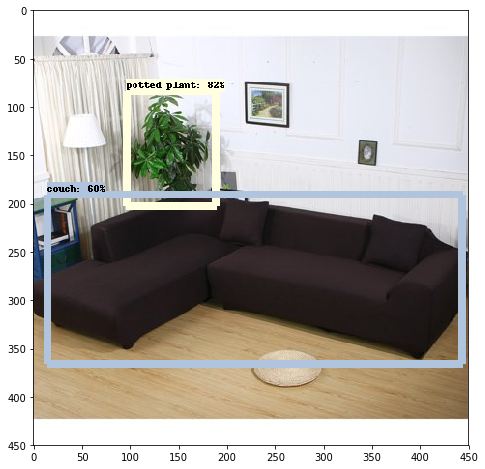

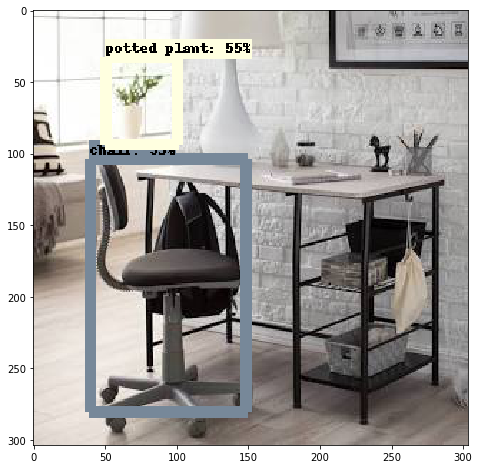

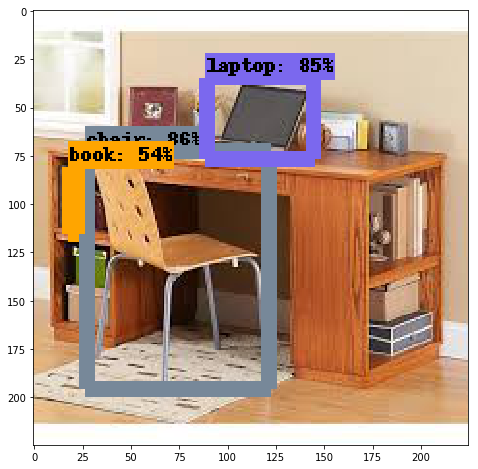

In [12]:
plot_images(TEST_IMAGE_PATHS)

## REST API Example

In [13]:
import requests

In [14]:
STATUS_URL = 'http://localhost:8501/v1/models/coco'
METADATA_URL = 'http://localhost:8501/v1/models/coco/metadata'
PREDICTION_URL = 'http://localhost:8501/v1/models/coco:predict'
FIRST_VERSION_PREDICTION_URL = 'http://localhost:8501/v1/models/coco/versions/1:predict'
HEADERS = {"content-type": "application/json"}

In [15]:
requests.get(STATUS_URL).json()

{'model_version_status': [{'version': '1',
   'state': 'AVAILABLE',
   'status': {'error_code': 'OK', 'error_message': ''}}]}

In [16]:
# Metadata
requests.get(METADATA_URL).json()

{'model_spec': {'name': 'coco', 'signature_name': '', 'version': '1'},
 'metadata': {'signature_def': {'signature_def': {'serving_default': {'inputs': {'input_image': {'dtype': 'DT_FLOAT',
       'tensor_shape': {'dim': [{'size': '-1', 'name': ''},
         {'size': '28', 'name': ''},
         {'size': '28', 'name': ''},
         {'size': '1', 'name': ''}],
        'unknown_rank': False},
       'name': 'Conv1_input_1:0'}},
     'outputs': {'Softmax_1/Softmax:0': {'dtype': 'DT_FLOAT',
       'tensor_shape': {'dim': [{'size': '-1', 'name': ''},
         {'size': '10', 'name': ''}],
        'unknown_rank': False},
       'name': 'Softmax_1/Softmax:0'}},
     'method_name': 'tensorflow/serving/predict'}}}}}

In [25]:
test_images = [np.expand_dims(load_image_into_numpy_array(Image.open(ii)), 0) 
               for ii in TEST_IMAGE_PATHS]



In [41]:
data = json.dumps({"signature_name": "serving_default", "instances": test_images[0].tolist()})

In [43]:
json_response = requests.post(PREDICTION_URL, data=data, headers=HEADERS)

In [45]:
json_response.json()

{'error': 'Generic conv implementation does not support grouped convolutions for now.\n\t [[{{node Conv1_1/Conv2D}} = Conv2D[T=DT_FLOAT, _output_shapes=[[?,13,13,8]], data_format="NHWC", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_Conv1_input_1_0_0, Conv1_1/Conv2D/ReadVariableOp)]]'}

### Still an open issue
- https://github.com/tensorflow/tensorflow/issues/3332